In [1]:
import functions as mf
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as la
from scipy.special import lambertw

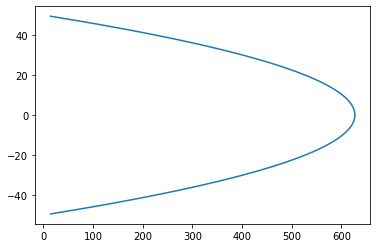

In [4]:
# Define the grid
Ny = 100
y_end = 100

# Define flow parameters
rho = 1
mu_0 = 1
pressure_difference = 1 * mu_0 / rho
pressure_boundary = np.array([4, 4]) * mu_0 / rho
boundary_condition = [1, 1] 

# Set the system up
system = mf.Multiflow(Ny, y_end, rho, pressure_difference ,pressure_boundary, boundary_condition, mu_0,0)
mu = system.calc_mu(mu_0)
velocity_laminar = system.simulate(mu)
plt.plot(velocity_laminar[1:-1], system.y[1:-1])
plt.show()

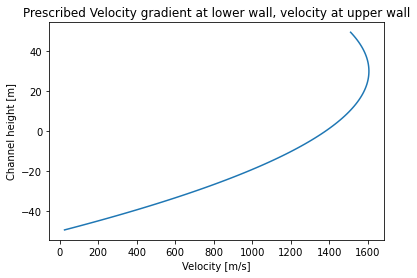

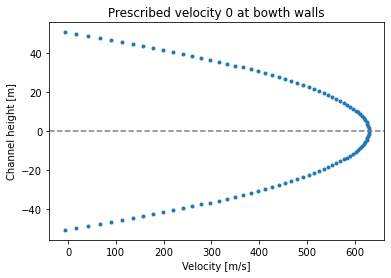

prescribed shear stress at wall


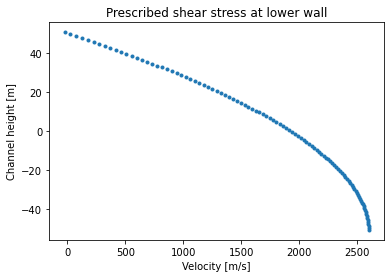

In [8]:
# velocity gradient is 0 at wall 1, velocity set at wall 2
boundary_condition = [1,-1]
pressure_boundary = [10, 10]
system_velocity_gradient = mf.Multiflow(Ny, y_end, rho, pressure_difference ,pressure_boundary, boundary_condition, mu_0,0)
solution = system_velocity_gradient.simulate(mu)
plt.plot(solution[1:-1], system_velocity_gradient.y[1:-1])
plt.title("Prescribed Velocity gradient at lower wall, velocity at upper wall")
plt.xlabel('Velocity [m/s]')
plt.ylabel('Channel height [m]')
plt.show()

# velocity is 0 at wall
boundary_condition = [1, 1]
system_velocity_zero = mf.Multiflow(Ny, y_end, rho, pressure_difference ,pressure_boundary, boundary_condition, mu_0,0)
solution = system_velocity_zero.simulate(mu)
plt.title("Prescribed velocity 0 at bowth walls")
plt.xlabel('Velocity [m/s]')
plt.ylabel('Channel height [m]')
plt.plot(solution,system_velocity_zero.y, '.')
plt.axhline(0, color='grey', linestyle='dashed')
plt.show()

# prescribed shear stress at wall
print("prescribed shear stress at wall")
stress = 1
boundary_condition = [-1, 1]
pressure_boundary = [-stress * (y_end / Ny) / mu[0], 0]
system_velocity_shear_stress = mf.Multiflow(Ny, y_end, rho, pressure_difference ,pressure_boundary, boundary_condition, mu_0,0)
solution = system_velocity_shear_stress.simulate(mu)
plt.title("Prescribed shear stress at lower wall")
plt.xlabel('Velocity [m/s]')
plt.ylabel('Channel height [m]')
plt.plot(solution,system_velocity_shear_stress.y, '.')
plt.show()


prantl mixing length

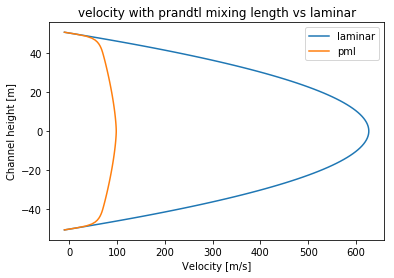

In [4]:
argument_type = "Spalding"

velocity_new = velocity_laminar

# Then calculate the solution with Prandtl mixing length
eps = 0.01
error = 1
i = 0

# Looping till solution converges
while error > eps:
    velocity = velocity_new

    # Calculate new effective viscosity
    mu_Prandtl = system.calc_mu_Prandtl(velocity, argument_type)

    # Calculate ensuing velocity
    velocity_new = system.simulate(mu_Prandtl)

    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    i+=1
    print("iteration", i, "with error", error, end='\r')

    if i > 2000:
        print("Oh nyo, it's bwoken")
        break

velocity_turbulent = velocity_new
mu_turbulent = mu_Prandtl

plt.plot(velocity_laminar, system.y, label="laminar")
plt.plot(velocity_new, system.y, label="pml")
plt.title("velocity with prandtl mixing length vs laminar")
plt.xlabel('Velocity [m/s]')
plt.ylabel('Channel height [m]')
plt.legend()
plt.show()


wall functions

206541.97775968924
iteration 1 with error 0.1761137869039785
iteration 2 with error 3.0038129583624578e-05
iteration 3 with error 1.803575722978852e-15
3


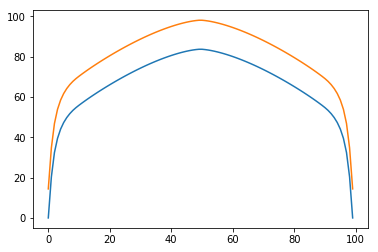

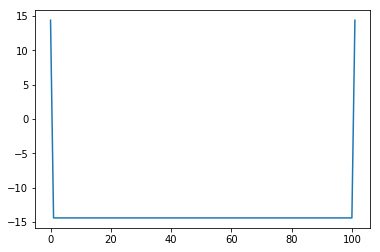

In [5]:
# Define constants
kappa = 0.41
E = 9.8
nu = 1e-6 #mu_turbulent / rho
B = 5.0

# Velocity profile
velocity_new = velocity_turbulent

# First round of calculating variables
u_1 = velocity_new[1]
lamberts_factor = abs(lambertw(u_1 * system.y_wall[1] * kappa * np.exp(kappa * B ) / nu))
u_tau = kappa * u_1 / lamberts_factor
y_plus = system.y_wall * u_tau / nu
print(y_plus[1])

# Define reference tau_w
tau_ref = system.pressure_difference[0] * y_end / 2

error  = 10
epsilon = 1e-7
i=0
while error > epsilon:
  velocity_old = velocity_new
  # Calculate new constant with u_tau != u_1 in log
  u_1 = velocity_new[1]
  lamberts_factor = abs(lambertw(u_1 * system.y_wall[1] * kappa * np.exp(kappa * B ) / nu))
  u_tau = kappa * u_1 / lamberts_factor

  # Calculate tau_w and new constant
  tau_w = rho * u_tau**2
  C = tau_w / u_1

  # Velocity shouldn't change on u_1
  velocity_new = system.simulate_wallfunctions(mu_turbulent, C, tau_w)
  
  error = np.abs(np.sum(velocity_new - velocity_old) / np.sum(velocity_old))
  i+=1
  print("iteration", i, "with error", error, end='\r')

print(i)
plt.plot(velocity_new[1:-1])
plt.plot(velocity_turbulent[1:-1])
plt.show()
plt.plot(velocity_new - velocity_turbulent)

In [6]:
print(tau_w, tau_ref)
print(y_plus)

6.629073405237845e-14 200.0
[ -206541.97775969   206541.97775969   619625.93327907  1032709.88879845
  1445793.84431782  1858877.7998372   2271961.75535658  2685045.71087596
  3098129.66639534  3511213.62191472  3924297.5774341   4337381.53295347
  4750465.48847285  5163549.44399223  5576633.39951161  5989717.35503099
  6402801.31055037  6815885.26606974  7228969.22158912  7642053.1771085
  8055137.13262788  8468221.08814726  8881305.04366664  9294388.99918602
  9707472.95470539 10120556.91022477 10533640.86574415 10946724.82126353
 11359808.77678291 11772892.73230229 12185976.68782166 12599060.64334104
 13012144.59886042 13425228.5543798  13838312.50989918 14251396.46541856
 14664480.42093793 15077564.37645731 15490648.33197669 15903732.28749607
 16316816.24301545 16729900.19853483 17142984.15405421 17556068.10957358
 17969152.06509296 18382236.02061234 18795319.97613172 19208403.9316511
 19621487.88717047 20034571.84268985 20447655.79820924 20447655.79820924
 20034571.84268985 196214

Euler-Euler

C:\Programs\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


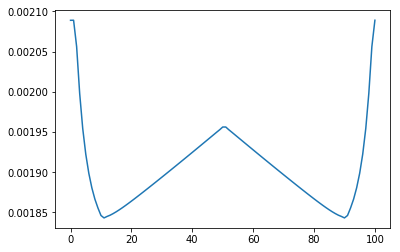

In [7]:
gamma = 1
sigma_d = 1
D_part = 0.04

mu_prandtl = mu_turbulent
nu_tau = mu_prandtl/system.rho
velocity = velocity_laminar

# Determine the velocity gradient
velocity_diff = (velocity[2:] - velocity[:-2]) / (system.y[2:] - system.y[:-2])
velocity_diff = np.append(velocity_diff, velocity_diff[-1])
velocity_diff = np.append(velocity_diff[0], velocity_diff)

# Assumption?????
diag_A1 = -(gamma*nu_tau*np.abs(velocity_diff))[0:-1]
c = 18 * mu_0 / (system.rho * sigma_d * D_part)
diag_A2 = -c * (nu_tau[:-1] + nu_tau[1:]) / 2
diag_A = diag_A1 + diag_A2

diag_B1 = (gamma * nu_tau * np.abs(velocity_diff))[1:]
diag_B2 = c * (nu_tau[:-1] + nu_tau[1:]) / 2
diag_B = diag_B1 + diag_B2

matrix_A = np.diag(diag_A, k=0) + np.diag(diag_B[:-1], k=1)

RHS = np.zeros(len(diag_A))
#RHS[int(len(RHS)/2)] = 1
RHS[-1] = 10/(10*system.dy)

alpha = la.spsolve(-matrix_A,RHS)
plt.plot(alpha)

In [11]:
mf.simulate_particles()

SyntaxError: invalid syntax (<ipython-input-11-7076fa043cb4>, line 36)